### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b047d60c-00c3-7251-2fba-537c87131af1)


In [3]:
# %%capture
!pip install accelerate
!pip install git+https://github.com/RishiDarkDevil/daam-t2i.git
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git
!pip install git+https://github.com/RishiDarkDevil/TITAN.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RishiDarkDevil/daam-t2i.git to /tmp/pip-req-build-dtra35yb
  Running command git clone --filter=blob:none --quiet https://github.com/RishiDarkDevil/daam-t2i.git /tmp/pip-req-build-dtra35yb
  Resolved https://github.com/RishiDarkDevil/daam-t2i.git to commit fafed0e77a04ad03821f8de84c120cb934b99aec
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/huggingface/transformers (to revision v4.29.2) to /tmp/pip-install-u3u5_lo8/transformers_fe66883a04e54a1b8bc4c5db66ea43a7
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-install-u3u5_lo8/transformers_fe66883a04e54a1b8bc4c5db66ea43a7
  Running command git checkout -q 5ab7665e776470080addac5d868e5fd784228805
  Resolved https://github.com/hugging

### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [4]:
# General
import requests
from io import BytesIO

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Image Generation
from diffusers import StableDiffusionPipeline

# Heatmap generation
import daamt2i
import daami2i

# Model
import torch

# annotations
import titan

### Load Model

In [5]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [6]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

In [7]:
prompt = ['A girl wearing winter clothes standing during snowfall.']
objects = ['girl', 'winter', 'clothes', 'snowfall']

In [8]:
# processed_prompt = titan.PromptHandler().clean_prompt(prompt)

In [9]:
# processed_prompt

In [10]:
with daamt2i.trace(model) as daam_trc:
  with daami2i.trace(model, track_all=True) as daami2i_trc:
    output_image = model(prompt=prompt).images[0]
    image_global_heat_map = daami2i_trc
    word_global_heat_map = daam_trc

  0%|          | 0/51 [00:00<?, ?it/s]

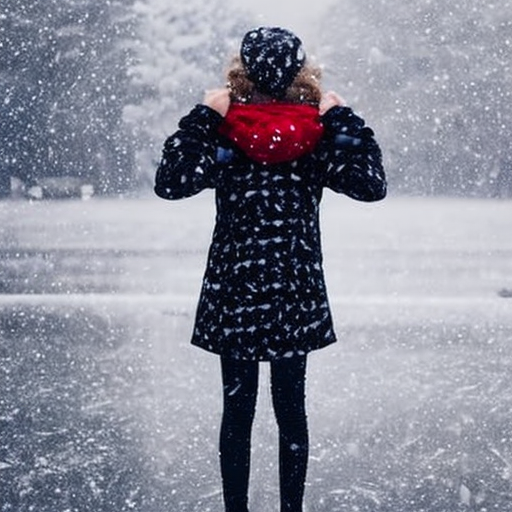

In [11]:
output_image

### Visualize Heatmaps

In [12]:
# Image2Image Attention Heatmap Aggregation for 1st Layer of UNet
image_global_heat_map1 = image_global_heat_map.compute_global_heat_map([1], None, None)
# Image2Image Attention Heatmap Aggregation for 2nd Layer of UNet
image_global_heat_map2 = image_global_heat_map.compute_global_heat_map([2], None, None)
# Image2Image Attention Heatmap Aggregation for 3rd Layer of UNet
image_global_heat_map4 = image_global_heat_map.compute_global_heat_map([4], None, None)
# Text2Image Attention Heatmap Aggregation for 1st Layer of UNet
word_global_heat_map1 = word_global_heat_map.compute_global_heat_map(factors=[1])
# Text2Image Attention Heatmap Aggregation for 2nd Layer of UNet
word_global_heat_map2 = word_global_heat_map.compute_global_heat_map(factors=[2])
# Text2Image Attention Heatmap Aggregation for 3rd Layer of UNet
word_global_heat_map4 = word_global_heat_map.compute_global_heat_map(factors=[4])

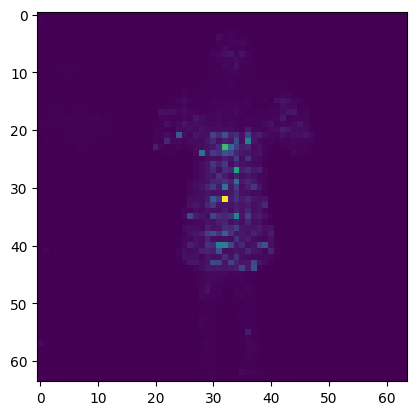

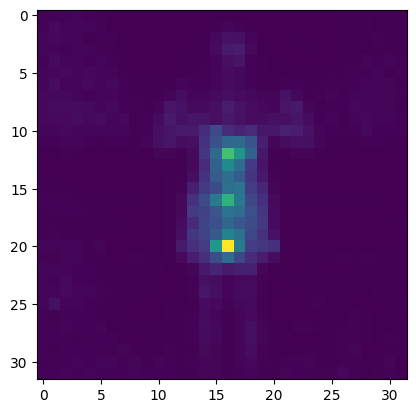

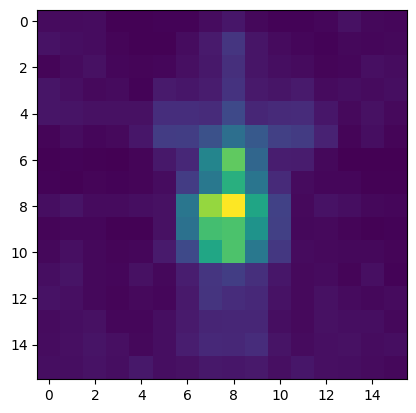

In [13]:
plt.imshow(image_global_heat_map1.compute_pixel_heat_map(32*64+32).heatmap)
plt.show()
plt.imshow(image_global_heat_map2.compute_pixel_heat_map((32//2)*32+(32//2)).heatmap)
plt.show()
plt.imshow(image_global_heat_map4.compute_pixel_heat_map((32//4)*16+(32//4)).heatmap)
plt.show()

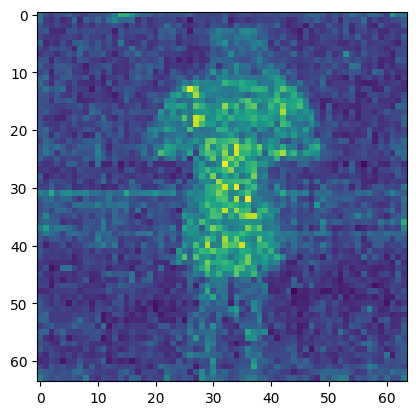

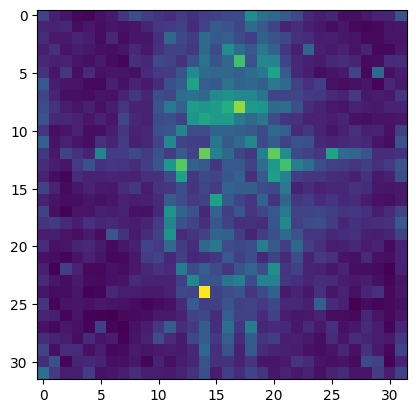

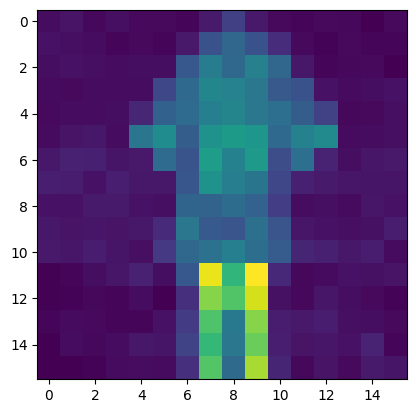

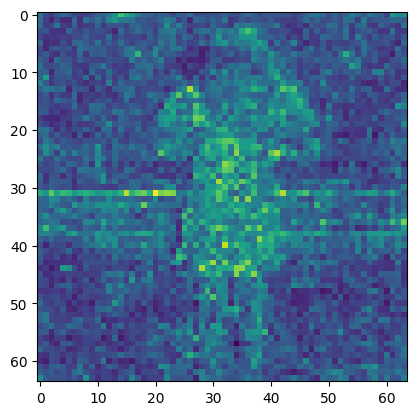

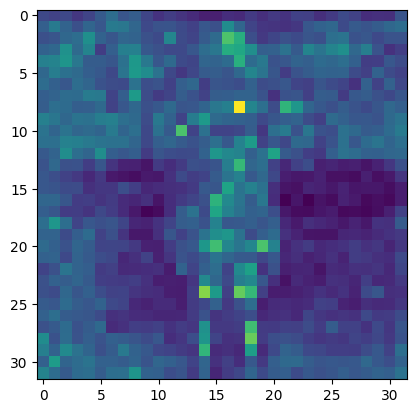

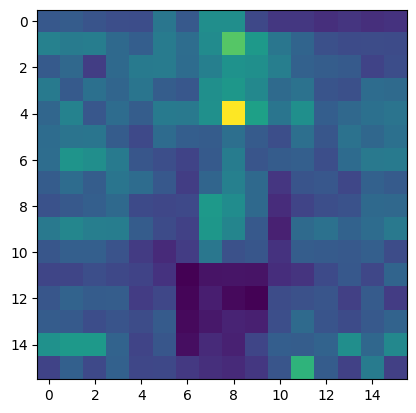

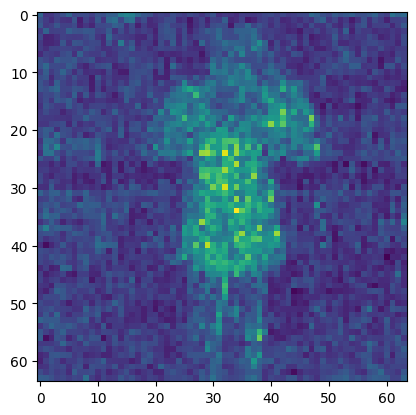

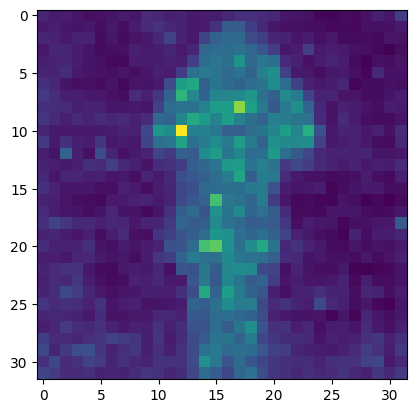

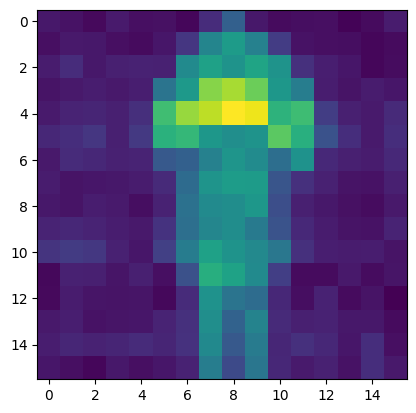

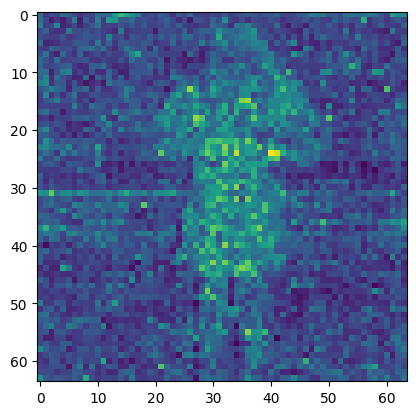

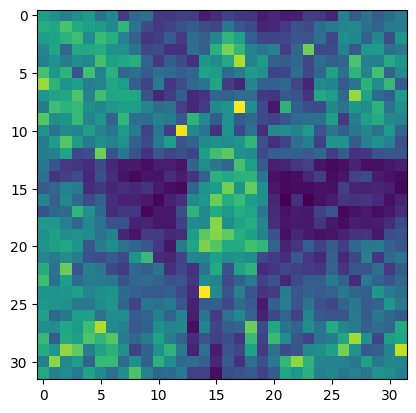

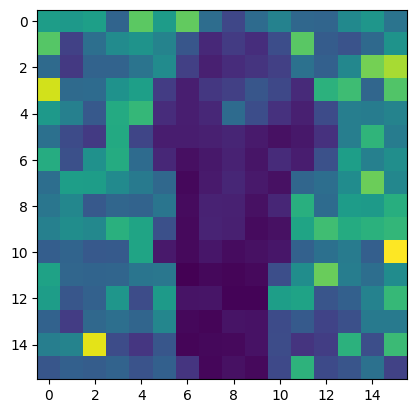

In [14]:
for i in range(len(objects)):
  plt.imshow(word_global_heat_map1.compute_word_heat_map(objects[i]).heatmap.cpu().numpy())
  plt.show()
  plt.imshow(word_global_heat_map2.compute_word_heat_map(objects[i]).heatmap.cpu().numpy())
  plt.show()
  plt.imshow(word_global_heat_map4.compute_word_heat_map(objects[i]).heatmap.cpu().numpy())
  plt.show()

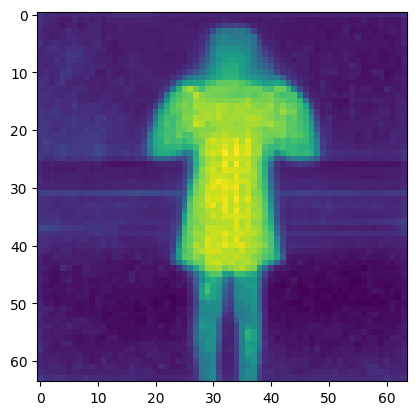

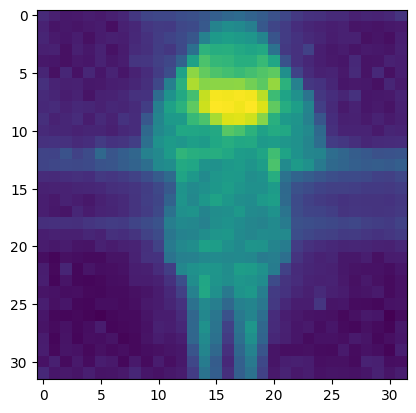

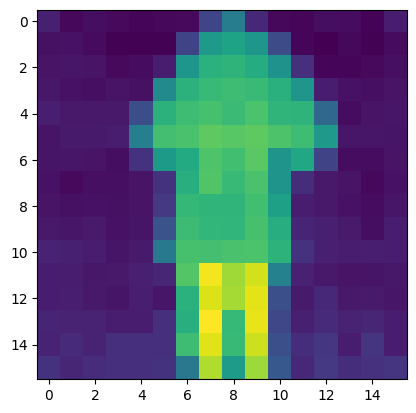

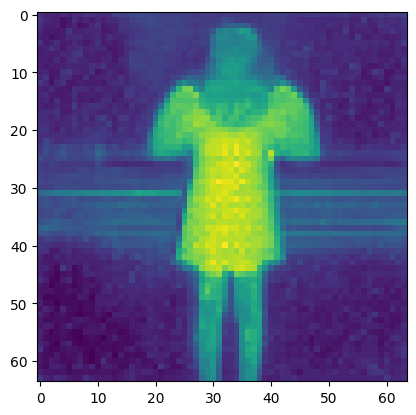

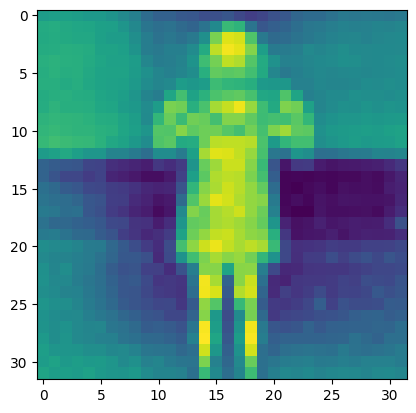

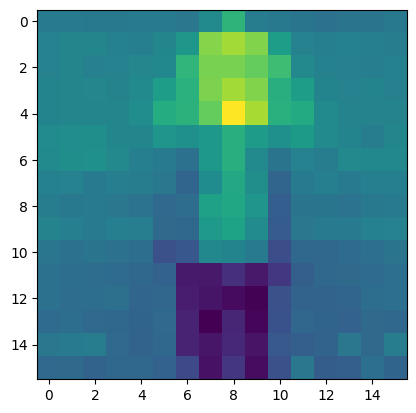

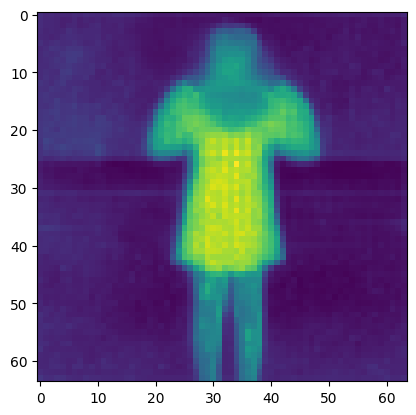

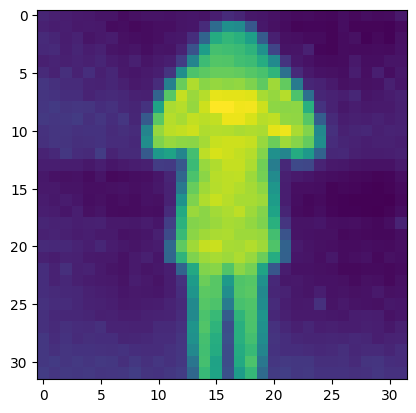

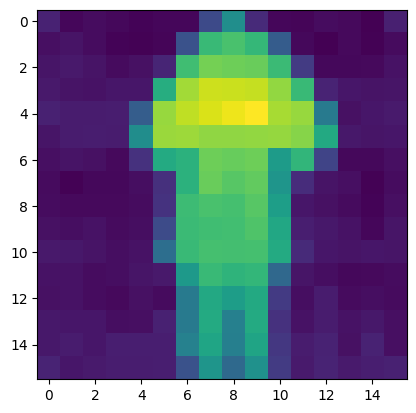

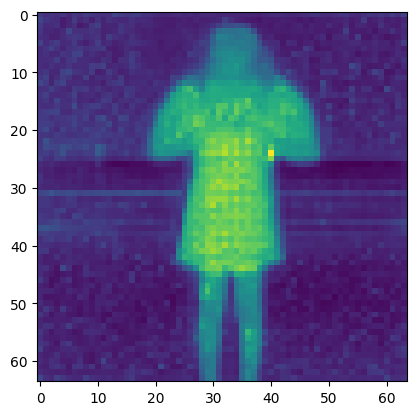

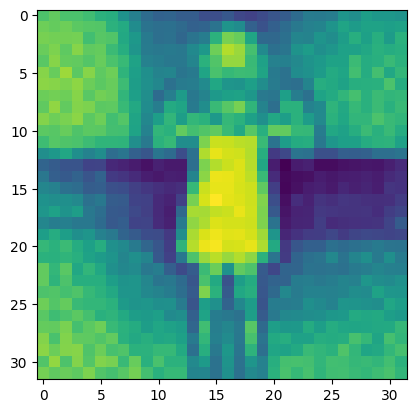

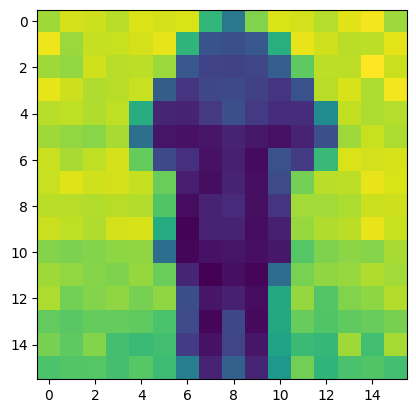

In [15]:
# Text Guided ImgAttn Fused
for i in range(len(objects)):
  word_heatmap = word_global_heat_map1.compute_word_heat_map(objects[i]).heatmap

  plt.imshow(image_global_heat_map1.compute_guided_heat_map(word_heatmap).heatmap)
  plt.show()

  word_heatmap = word_global_heat_map2.compute_word_heat_map(objects[i]).heatmap

  plt.imshow(image_global_heat_map2.compute_guided_heat_map(word_heatmap).heatmap)
  plt.show()

  word_heatmap = word_global_heat_map4.compute_word_heat_map(objects[i]).heatmap

  plt.imshow(image_global_heat_map4.compute_guided_heat_map(word_heatmap).heatmap)
  plt.show()

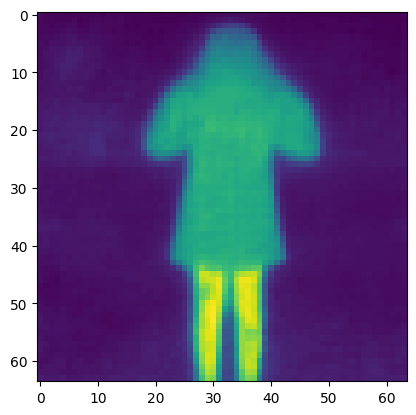

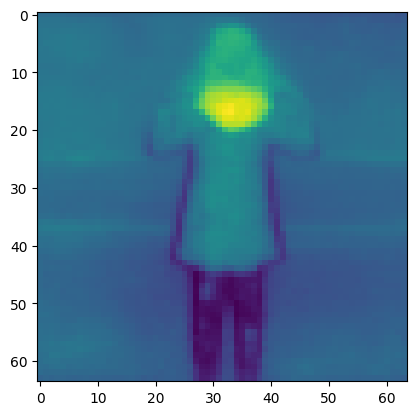

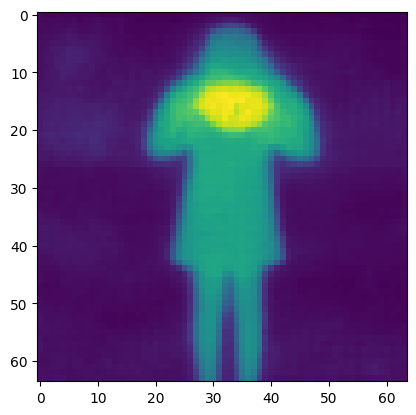

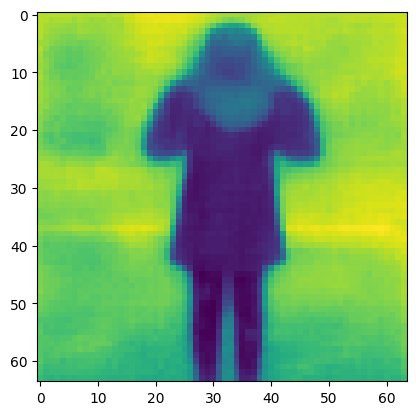

In [22]:
# Smallest Word Heatmap Layer to Largest UNet Layer Image Attn Fused Heatmap
for i in range(len(objects)):
  word_heatmap = word_global_heat_map4.compute_word_heat_map(objects[i]).expand_as(output_image.resize((64, 64)))
  plt.imshow(image_global_heat_map1.compute_guided_heat_map(word_heatmap).heatmap)
  plt.show()

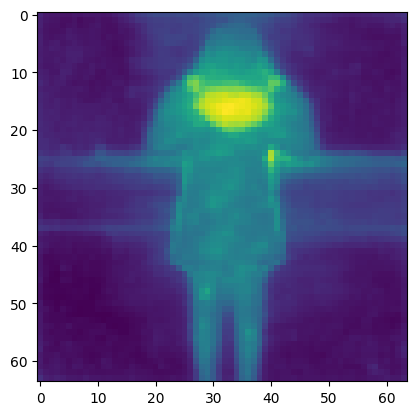

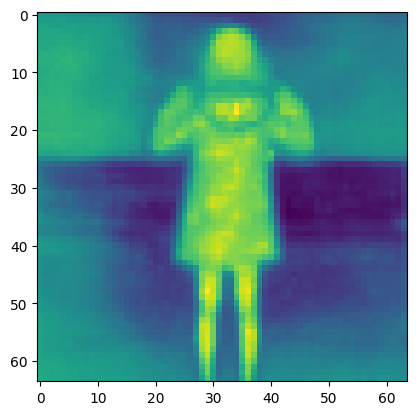

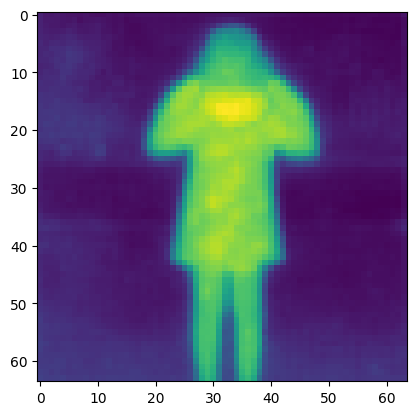

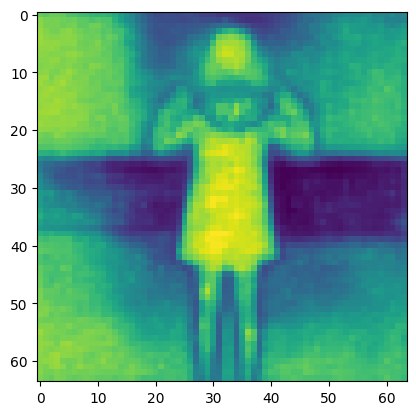

In [23]:
# Second Smallest Word Heatmap Layer to Largest UNet Layer Image Attn Fused Heatmap
for i in range(len(objects)):
  word_heatmap = word_global_heat_map2.compute_word_heat_map(objects[i]).expand_as(output_image.resize((64, 64)))
  plt.imshow(image_global_heat_map1.compute_guided_heat_map(word_heatmap).heatmap)
  plt.show()

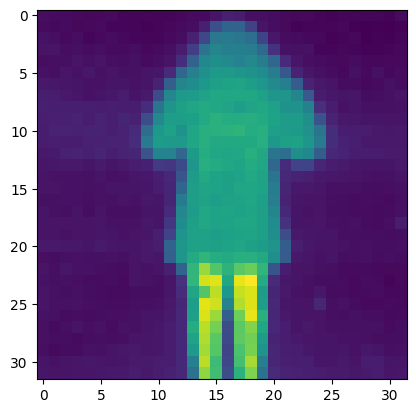

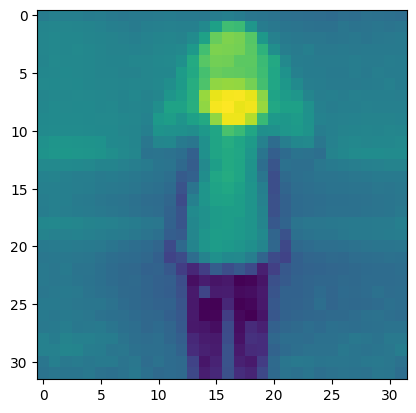

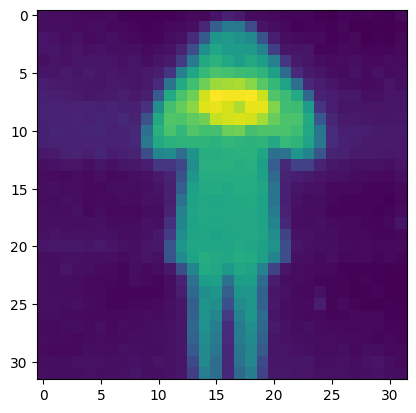

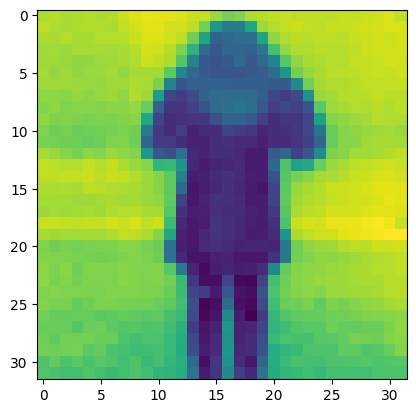

In [25]:
# Smallest Word Heatmap Layer to Second UNet Layer Image Attn Fused Heatmap
for i in range(len(objects)):
  word_heatmap = word_global_heat_map4.compute_word_heat_map(objects[i]).expand_as(output_image.resize((32, 32)))
  plt.imshow(image_global_heat_map2.compute_guided_heat_map(word_heatmap).heatmap)
  plt.show()

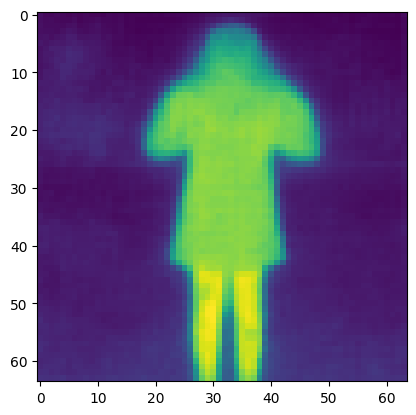

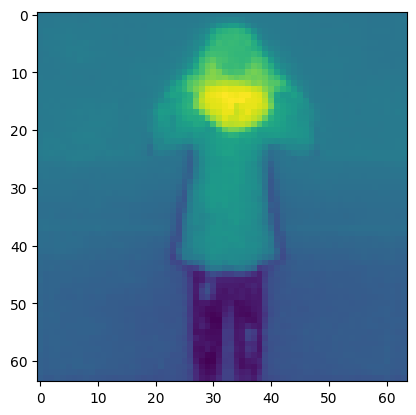

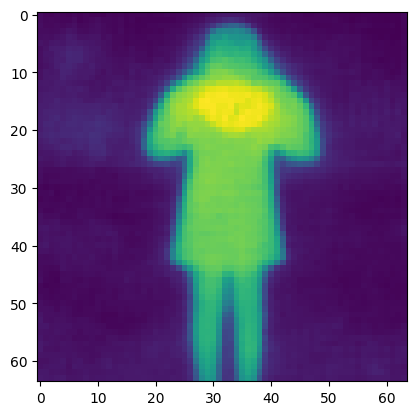

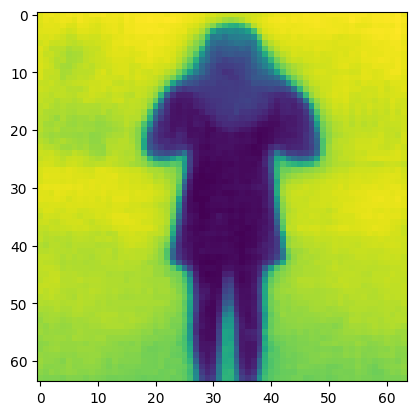

In [27]:
# Smallest Word Heatmap Layer with Image Attn Fused to First UNet Layer Image Attn Fusing Heatmap
for i in range(len(objects)):
  word_heatmap = word_global_heat_map4.compute_word_heat_map(objects[i]).heatmap
  word_heatmap_img_attn = image_global_heat_map4.compute_guided_heat_map(word_heatmap).expand_as(output_image.resize((64, 64)))
  plt.imshow(image_global_heat_map1.compute_guided_heat_map(word_heatmap_img_attn).heatmap)
  plt.show()

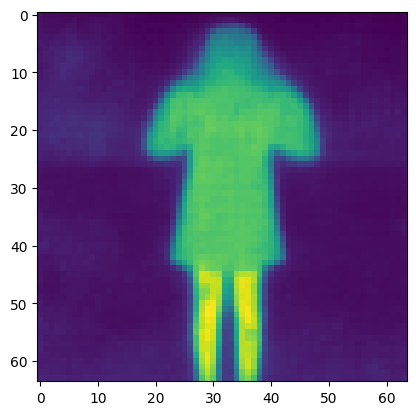

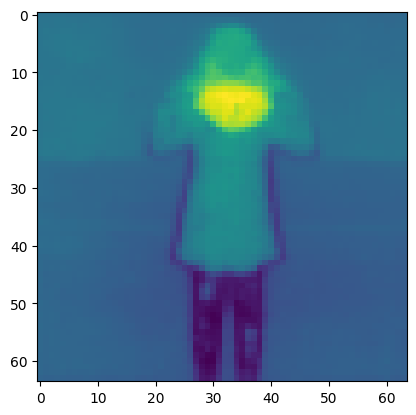

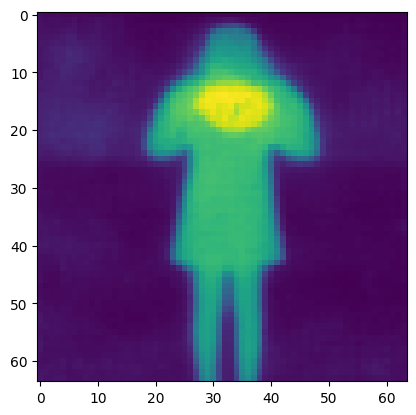

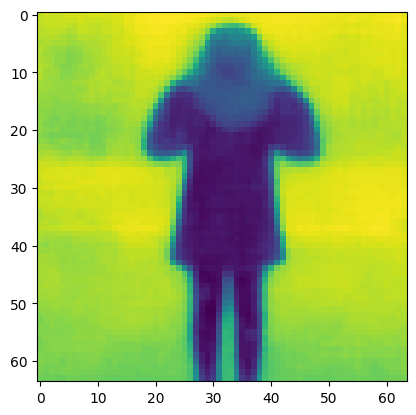

In [29]:
# Smallest Word Heatmap Layer with 2nd Layer Image Attn Fused to First UNet Layer Image Attn Fusing Heatmap
for i in range(len(objects)):
  word_heatmap = word_global_heat_map4.compute_word_heat_map(objects[i]).expand_as(output_image.resize((32, 32)))
  word_heatmap_img_attn = image_global_heat_map2.compute_guided_heat_map(word_heatmap).expand_as(output_image.resize((64, 64)))
  plt.imshow(image_global_heat_map1.compute_guided_heat_map(word_heatmap_img_attn).heatmap)
  plt.show()

In [ ]:
# Pixel Attention Diffusion Image diffusion
NUM_DIFFUSE = 20
PIXEL_ID = 25*64 + 50 # Enter Pixel ID
heatmap = image_global_heat_map.compute_pixel_diffused_heat_map(PIXEL_ID, 'thresholding', NUM_DIFFUSE, 0.02, True)

In [ ]:
heatmap.plot_overlay(output_image)

In [ ]:
heatmap = image_global_heat_map.compute_diffused_heat_map('thresholding', NUM_DIFFUSE, 0.015)

In [ ]:
plt.imshow(heatmap.compute_pixel_heat_map(PIXEL_ID).heatmap)

In [ ]:
heatmap.compute_pixel_heat_map(PIXEL_ID).plot_overlay(output_image)

In [ ]:
object_annotator = titan.ObjectAnnotator()

In [ ]:
ann = object_annotator.wordheatmap_to_annotations(heatmap.compute_pixel_heat_map(PIXEL_ID).expand_as(output_image).numpy(), use_nms=False, skip_small_filters=True)
object_annotator.show_annotations(np.asarray(output_image), ann, draw_bbox=False)

In [ ]:
plt.imshow(heatmap.compute_pixel_heat_map(63*64+63).heatmap)

In [ ]:
heatmap.compute_pixel_heat_map(63*64+63).plot_overlay(output_image)

In [ ]:
ann = object_annotator.wordheatmap_to_annotations(heatmap.compute_pixel_heat_map(63*64+63).expand_as(output_image).numpy(), use_nms=False, skip_small_filters=True)
object_annotator.show_annotations(np.asarray(output_image), ann, draw_bbox=False)

In [ ]:
plt.imshow(heatmap.compute_pixel_heat_map(25*64+50).heatmap)

In [ ]:
for i in range(0, 64, 8):
  for j in range(0, 64, 8):
    plt.imshow(heatmap.compute_pixel_heat_map(i*64+j).heatmap)
    plt.show()